In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression

In [2]:
X_full, y_full = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [3]:
nines_idx = y_full == '9'

In [4]:
X_positive = X_full[nines_idx]
y_positive = y_full[nines_idx]

X_negative = X_full[np.invert(nines_idx)]
y_negative = y_full[np.invert(nines_idx)]

In [5]:
print(Counter(y_positive))
print(Counter(y_negative))

Counter({'9': 6958})
Counter({'1': 7877, '7': 7293, '3': 7141, '2': 6990, '0': 6903, '6': 6876, '8': 6825, '4': 6824, '5': 6313})


In [6]:
permutation = np.random.permutation(len(X_negative))
sample = np.random.choice(permutation, size=len(X_positive))
X_negative = X_full[sample]
y_negative = y_full[sample]

In [7]:
len(X_negative)

6958

In [8]:
print(Counter(y_negative))

Counter({'1': 759, '2': 745, '0': 712, '3': 708, '7': 700, '6': 683, '9': 672, '4': 667, '8': 665, '5': 647})


In [9]:
X = np.concatenate((X_positive, X_negative))
y = np.concatenate((np.ones(len(X_positive)), np.zeros(len(X_negative))))
permutation = np.random.permutation(len(X))
X = X[permutation]
y = y[permutation]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
train_samples = len(X_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(
    C=50. / train_samples, penalty='l1', solver='saga', tol=0.1
)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)

In [11]:
clf.predict_proba([X_test[2]])

array([[0.72510998, 0.27489002]])

In [12]:
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

Sparsity with L1 penalty: 66.33%
Test score with L1 penalty: 0.8477


In [13]:
from sklearn.metrics import brier_score_loss

In [14]:
y_test[2]

0.0

In [15]:
clf.predict_proba(X)

array([[1.00000000e+00, 8.71798370e-13],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 3.08054466e-87],
       ...,
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00]])

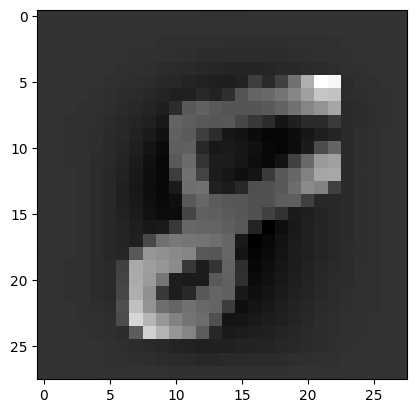

In [16]:
plt.imshow(X_test[2].reshape(28,28), cmap='gray')
plt.show()

In [64]:
def plot_calibration(clf, X, y, save_calibration_model=False, calibration_model_name=None):
    def plot_calibration_curve(ground_truth, probs, title):
        calib_prob_true, calib_prob_pred = calibration_curve(ground_truth, probs, n_bins=20)
        brier_score = brier_score_loss(ground_truth, new_probs)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(*zip(*sorted(zip(*(calib_prob_true, calib_prob_pred)))), marker='.', color='orange')
        plt.title(f'{title}\nBrier score: {round(brier_score, 4)}')

    overlay_probs = clf.predict_proba(X)[:,1]
    ground_truth = y
    prob_true, prob_pred = calibration_curve(ground_truth, overlay_probs, n_bins=20)
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=0.4) 

    plt.subplot(3,2,1)
    brier_score = brier_score_loss(ground_truth, overlay_probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.', color='orange')
    plt.title(f'Before calibration\nBrier score: {round(brier_score, 4)}')
    
#     plt.subplot(3,2,3)
#     prob_pred_calib, alpha, beta = platt_scaling(prob_pred, prob_true)
#     plt.plot([0, 1], [0, 1], alpha=0)
#     plt.plot(prob_pred, prob_true, marker='.', color='orange')
#     plt.plot(prob_pred[1:-1], prob_pred_calib, color='red')
#     plt.title(f'Fitted logistic regression')
    
#     plt.subplot(3,2,4)
#     new_probs = 1 / (1 + np.exp(alpha * np.array(overlay_probs) + beta))
#     plot_calibration_curve(ground_truth, new_probs, 'After calibration with Platt scaling')
    
    plt.subplot(3,2,5)
    isotonic_model = isotonic_regression(prob_pred, prob_true)
    if save_calibration_model:
        os.makedirs('model', exist_ok=True)
        if not calibration_model_name:
            calibration_model_name = model.model_id + "_calibration"
        model_path = f'model/{calibration_model_name}.pmml'
        isotonic2pmml.topmml(isotonic = model, 
                         datafield_name = 'probability', 
                         targetfield_name = 'calibrated_probablity', 
                         outputfile = model_path, 
                         xs=prob_pred, 
                         ys=isotonic_model.transform(prob_pred))
        print(f"Saved calibration model at {model_path}")

    plt.plot([0, 1], [0, 1], alpha=0)
    plt.plot(prob_pred, prob_true, marker='.', color='orange')
    plt.plot(isotonic_model.X_thresholds_, isotonic_model.y_thresholds_, color='red')
    plt.title(f'Fitted isotonic regression')
    
    plt.subplot(3,2,6)
    new_probs = isotonic_model.predict(overlay_probs)
    plot_calibration_curve(ground_truth, new_probs, 'After calibration with isotonic regression')
    plt.show()

def platt_scaling(prob_pred, prob_true):
    print(prob_true, prob_pred)
    prob_true = np.log((1 / np.array(prob_true)) - 1)[1:-1]
    prob_pred = prob_pred[1:-1]
    model = LinearRegression().fit(prob_pred.reshape(-1, 1), prob_true.reshape(-1, 1))
    alpha = model.coef_[0, 0]
    beta = model.predict([[0]])[0, 0]
    return 1 / (1 + np.exp(alpha * np.array(prob_pred) + beta)), alpha, beta

def isotonic_regression(prob_pred, prob_true):
    return IsotonicRegression(out_of_bounds='clip').fit(prob_pred, prob_true)

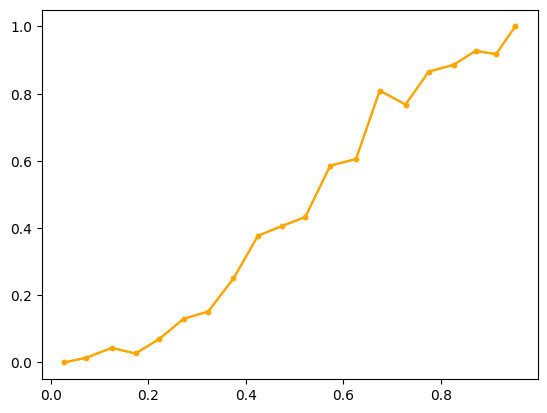

In [73]:
probs = clf.predict_proba(X_test)
prob_true, prob_pred=calibration_curve(y_test, probs[:,1], n_bins=20)
plt.plot(prob_pred, prob_true, marker='.', color='orange')
plt.show()

<ipython-input-27-6134d00a9e59>:58: RuntimeWarning: divide by zero encountered in true_divide
  prob_true = np.log((1 / np.array(prob_true)) - 1)[1:-1]
<ipython-input-27-6134d00a9e59>:58: RuntimeWarning: divide by zero encountered in log
  prob_true = np.log((1 / np.array(prob_true)) - 1)[1:-1]


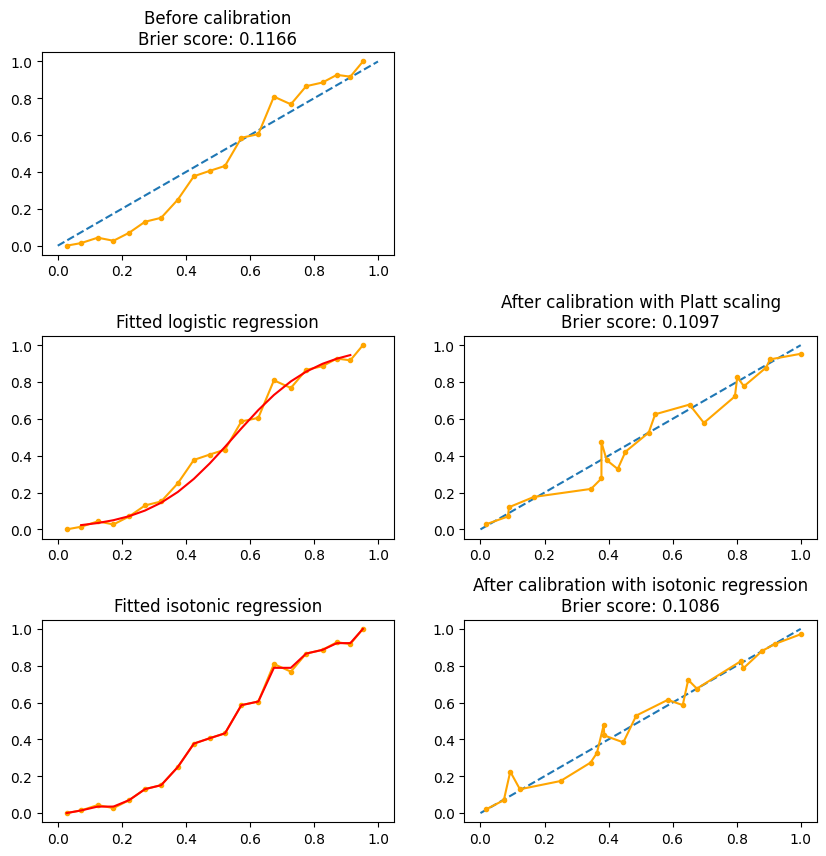

In [28]:
plot_calibration(clf, X_test, y_test)

C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


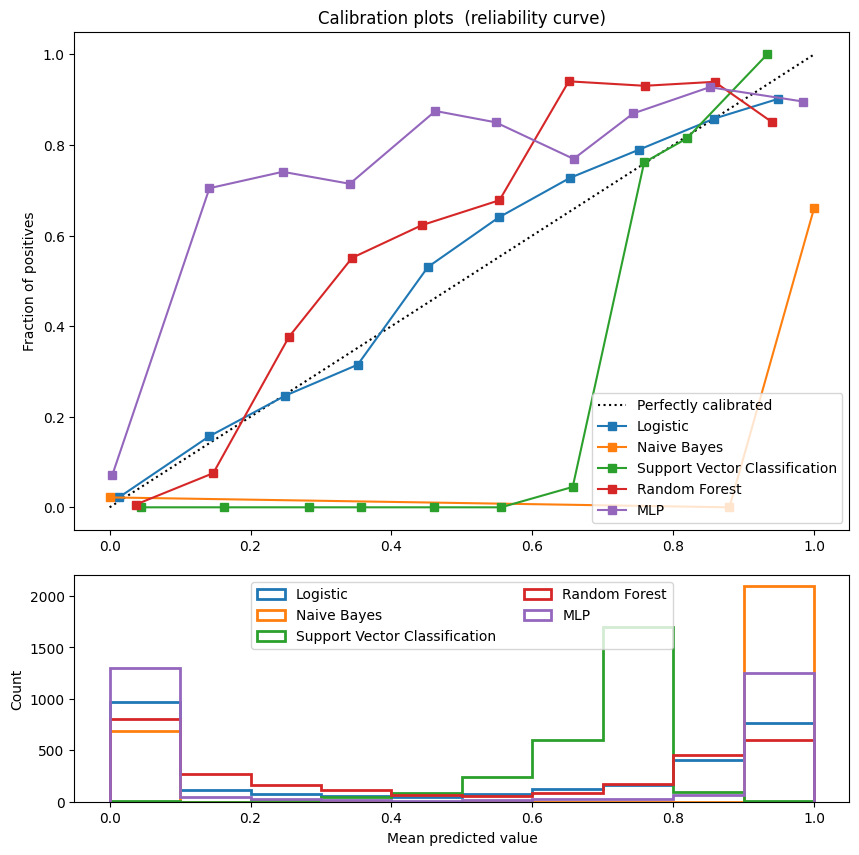

In [99]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.neural_network import MLPClassifier
# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()
mlp = MLPClassifier()

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                 (mlp, 'MLP')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
plt.show()